Validation of noise models for single-cell transcriptomics

_Grün et al., Nature Methods, 2014_

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt

from scipy.stats import norm
from statsmodels.distributions.empirical_distribution import ECDF

In [2]:
from negbin_val_functions import *

read and prepare data

In [3]:
data = pd.read_csv("/home/npapado/Documents/data/GSE54695/GSE54695_data_transcript_counts.txt", sep = "\t")
print(data.shape)

spike_rows = [i for i, col in enumerate(data["GENENAME"]) if 'ERCC' in col]
data = data.drop(spike_rows, 0)
print(data.shape)

gene_names = data["GENENAME"].get_values()

data = data.drop("GENENAME", 1)
print(data.shape)

(12535, 321)
(12485, 321)
(12485, 320)


fit the different subsets separately

In [4]:
all2i = np.array([i for i, col in enumerate(data.columns) if '2i' in col])
allserum = np.array([i for i, col in enumerate(data.columns) if 'serum' in col])

cells = np.array([i for i, s in enumerate(data.columns) if "SC" in s])
controls = np.array([i for i, s in enumerate(data.columns) if "RNA" in s])

In [5]:
cells2i = np.intersect1d(cells, all2i)
cellsserum = np.intersect1d(cells, allserum)

In [6]:
# see Quantification of transcript abundance in Grün et al. for Pou5f control
X = np.array(data).transpose()
keep = np.sum(X, axis=1) > 1000
relevant = np.sum(X, axis=0) > 0
pou5f = [i for i, col in enumerate(gene_names[relevant]) if 'Pou5f' in col][0]
X = X[keep][:, relevant]
sum_all = np.sum(X, axis=1)
scalings = sum_all / np.mean(sum_all)

X = (X.transpose() / scalings).transpose()
not_differentiating = np.where(X[:, pou5f] > 10)
X = X[:, not_differentiating]

In [7]:
X = np.array(data.iloc[:,cells2i]).transpose()
keep = np.sum(X, axis=1) > 1000
relevant = np.sum(X, axis=0) > 0
X = X[keep][:, relevant]
G = X.shape[1]

# scaling and normalization by scaling
sum_all = np.sum(X, axis=1)
scalings = sum_all / np.mean(sum_all)
np.savetxt("gse5/cells2i_scalings.txt", scalings)

X = (X.transpose() / scalings).transpose()

norm_pvals, mu_res, s2_res = fit_normals(G, X)
pois_pvals, lambda_res, pois_success = fit_poissons(G, X)
negbin_pvals, a_res, b_res, nb_success = fit_negbins(G, X)

norm_all = [norm_pvals, mu_res, s2_res]
pois_all = [pois_pvals, lambda_res, pois_success]
negbin_all = [negbin_pvals, a_res, b_res, nb_success]

save_all("gse5", "cells2i", norm_all, pois_all, negbin_all)

/home/npapado/Documents/repos/prosst-scripts/negbin_val_functions.py:196: RuntimeWarning: divide by zero encountered in log
  s2 = X * np.log(p)
/home/npapado/Documents/repos/prosst-scripts/negbin_val_functions.py:196: RuntimeWarning: invalid value encountered in multiply
  s2 = X * np.log(p)


In [8]:
X = np.array(data.iloc[: ,cellsserum]).transpose()
keep = np.sum(X, axis=1) > 1000
relevant = np.sum(X, axis=0) > 0
X = X[keep][:, relevant]
G = X.shape[1]

# scaling and normalization by scaling
sum_all = np.sum(X, axis=1)
scalings = sum_all / np.mean(sum_all)
np.savetxt("gse5/serum_scalings.txt", scalings)

X = (X.transpose() / scalings).transpose()

norm_pvals, mu_res, s2_res = fit_normals(G, X)
pois_pvals, lambda_res, pois_success = fit_poissons(G, np.rint(X).astype(int))
negbin_pvals, a_res, b_res, nb_success = fit_negbins(G, np.rint(X).astype(int))

norm_all = [norm_pvals, mu_res, s2_res]
pois_all = [pois_pvals, lambda_res, pois_success]
negbin_all = [negbin_pvals, a_res, b_res, nb_success]

save_all("gse5", "serum", norm_all, pois_all, negbin_all)

/home/npapado/Documents/repos/prosst-scripts/negbin_val_functions.py:196: RuntimeWarning: divide by zero encountered in log
  s2 = X * np.log(p)
/home/npapado/Documents/repos/prosst-scripts/negbin_val_functions.py:196: RuntimeWarning: invalid value encountered in multiply
  s2 = X * np.log(p)


0.9999999999999998 0.5516772116132427


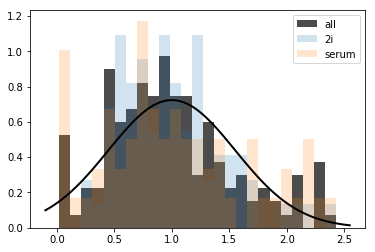

In [9]:
# scaling factors
fig, ax = plt.subplots()

data2i = np.array(data.iloc[: ,cells2i]).transpose()
keep2i = np.sum(data2i, axis=1) > 1000
dataserum = np.array(data.iloc[: ,cellsserum]).transpose()
keepserum = np.sum(dataserum, axis=1) > 1000

sum1 = np.sum(data2i[keep2i], axis=1)
sum2 = np.sum(dataserum[keepserum], axis=1)
sum_all = np.concatenate([sum1, sum2])

from scipy.stats import norm
scalings = sum_all / np.mean(sum_all)
mu, std = norm.fit(scalings)

all_n, all_bins, all_patches = ax.hist(scalings, bins=25, normed=True, alpha=0.7, color='black', label="all")

# Plot the PDF.
xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
ax.plot(x, p, 'k', linewidth=2)
print(mu, std)

ax.hist(sum1/np.mean(sum1), bins=all_bins, normed=True, alpha=0.2, label="2i")
np.savetxt("gse5/cells2i_scalings.txt", sum1/np.mean(sum1))
ax.hist(sum2/np.mean(sum2), bins=all_bins, normed=True, alpha=0.2, label="serum")
np.savetxt("gse5/serum_scalings.txt", sum2/np.mean(sum2))
ax.legend()
plt.show()

0.3098291187095087 2.5627505824519523
1.9315880309188649 1.418927024258064


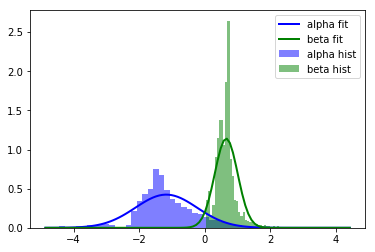

In [10]:
mu_a, std_a = norm.fit(np.log(a_res[nb_success]))
mu_b, std_b = norm.fit(np.log(b_res[nb_success]))

fig, ax = plt.subplots()
ax.hist(np.log(a_res[nb_success]), label="a", bins=50, alpha=0.5, normed=True, color="blue")
ax.hist(np.log(b_res[nb_success]), label="b", bins=50, alpha=0.5, normed=True, color="green")

# Plot the PDF.
xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax, 100)
pa = norm.pdf(x, mu_a, std_a)
pb = norm.pdf(x, mu_b, std_b)
ax.plot(x, pa, 'k', linewidth=2, label="a", color="blue")
ax.plot(x, pb, 'k', linewidth=2, label="b", color="green")
print(np.exp(mu_a), np.exp(std_a))
print(np.exp(mu_b), np.exp(std_b))
ax.legend(labels=["alpha fit", "beta fit", "alpha hist", "beta hist"])

In [11]:
data2i = np.array(data.iloc[: ,cells2i]).transpose()
keep2i = np.sum(data2i, axis=1) > 1000
dataserum = np.array(data.iloc[: ,cellsserum]).transpose()
keepserum = np.sum(dataserum, axis=1) > 1000

X = data2i[keep2i]
relevant = np.sum(X, axis=0) > 0
X = X[:, relevant]
gene_means = np.mean(X, axis=0)
np.savetxt("gse5/cells2i_genes.txt", gene_means)

X = dataserum[keepserum]
relevant = np.sum(X, axis=0) > 0
X = X[:, relevant]
gene_means = np.mean(X, axis=0)
np.savetxt("gse5/serum_genes.txt", gene_means)